In [28]:
import torch
import torch.nn as nn
import torch.distributions as dist
import numpy as np
# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


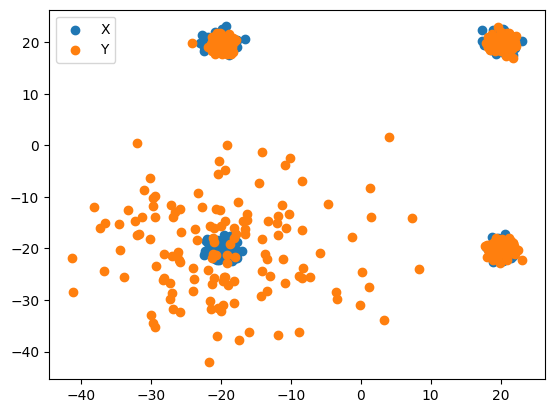

In [103]:
# generate samples and plot them
from utils import sampler_mixture
import matplotlib.pyplot as plt
X,Y = sampler_mixture(
    0,
    500,
    500,
    2,
    mu=20,
    std_1=1,
    std_2=10,)

plt.scatter(X[:, 0], X[:, 1], label='X')
plt.scatter(Y[:, 0], Y[:, 1], label='Y')
plt.legend()
plt.show()

In [3]:
from utils import RJSD_estimator

In [7]:
repetitions = 200
shifts = (0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2)
sample_size = 500

RJSD_est = RJSD_estimator(isotropic = False)
outputs = np.zeros((len(shifts), repetitions))
outputs = outputs.tolist()
seed = 42
# set torch and numpy seeds
torch.manual_seed(seed)
np.random.seed(seed)

# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for s in (range(len(shifts))):
    shift = shifts[s]
    print('shift:', shift)
    for i in (range(repetitions)):
        X, Y = sampler_mixture(seed = seed, m=sample_size, n=sample_size, d=2, mu=20, std_1=1, std_2=shift)
        seed += 1
        X = X.to(device)
        Y = Y.to(device)
        RJSD_est.fit(X, Y)
        outputs[s][i] = RJSD_est.permutation_test(X, Y, permutations=2000, seed = seed)

output = np.mean(np.array(outputs), -1)



shift: 0.5
shift: 0.6
shift: 0.7
shift: 0.8
shift: 0.9
shift: 1
shift: 1.2
shift: 1.4
shift: 1.6
shift: 1.8
shift: 2


In [5]:
# testing deep RJSD
repetitions = 1
shifts = (0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2)
sample_size = 500

RJSD_est = RJSD_estimator(deep = True)
outputs = np.zeros((len(shifts), repetitions))
outputs = outputs.tolist()
seed = 42
# set torch and numpy seeds
torch.manual_seed(seed)
np.random.seed(seed)

# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for s in (range(len(shifts))):
    shift = shifts[s]
    print('shift:', shift)
    for i in (range(repetitions)):
        X, Y = sampler_mixture(seed = seed, m=sample_size, n=sample_size, d=2, mu=20, std_1=1, std_2=shift)
        seed += 1
        X = X.to(device)
        Y = Y.to(device)
        RJSD_est.fit(X, Y, epochs = 1000, lr = 0.0005, verbose = True)
        outputs[s][i] = RJSD_est.permutation_test(X, Y, permutations=500, seed = seed) # 500

output = np.mean(np.array(outputs), -1)

shift: 0.5
Iteration: 0, Divergence: 0.00652003288269043
Iteration: 50, Divergence: 0.009405851364135742
Iteration: 100, Divergence: 0.009807586669921875
Iteration: 150, Divergence: 0.009963035583496094
Iteration: 200, Divergence: 0.011577844619750977
Iteration: 250, Divergence: 0.011273026466369629
Iteration: 300, Divergence: 0.011608123779296875
Iteration: 350, Divergence: 0.011291742324829102
Iteration: 400, Divergence: 0.012998461723327637
Iteration: 450, Divergence: 0.012282371520996094
Iteration: 500, Divergence: 0.012711167335510254
Iteration: 550, Divergence: 0.011955022811889648
Iteration: 600, Divergence: 0.012632250785827637
Iteration: 650, Divergence: 0.011898517608642578
Iteration: 700, Divergence: 0.012294769287109375
Iteration: 750, Divergence: 0.013072371482849121
Iteration: 800, Divergence: 0.013299942016601562
Iteration: 850, Divergence: 0.01255035400390625
Iteration: 900, Divergence: 0.01273643970489502
Iteration: 950, Divergence: 0.012874364852905273
shift: 0.6
Iter

In [108]:
from utils import RJSD

def rjsdfuse(
    X,
    Y,
    seed,
    order_approx = 4,
    alpha=0.05,
    kernels=("laplace", "gaussian"),
    lambda_multiplier=1,
    number_bandwidths=10,
    number_permutations=2000,
    return_p_val=False,
):
    """
    Two-Sample RJSD-FUSE test.

    Code adapted from the JAX version of MMD-FUSE by Schrab et al. (2021).

    Given data from one distribution and data from another distribution,
    return 0 if the test fails to reject the null
    (i.e. data comes from the same distribution),
    or return 1 if the test rejects the null
    (i.e. data comes from different distributions).


    Parameters
    ----------
    X : tensor
        The shape of X must be of the form (m, d) where m is the number
        of samples and d is the dimension.
    Y: array_like
        The shape of X must be of the form (n, d) where m is the number
        of samples and d is the dimension.
    key:
        Jax random key (can be generated by jax.random.PRNGKey(seed) for an integer seed).
    alpha: scalar
        The value of alpha (level of the test) must be between 0 and 1.
    kernels: str or list
        The list should contain strings.
        The value of the strings must be: "gaussian", "laplace", "imq", "matern_0.5_l1",
        "matern_1.5_l1", "matern_2.5_l1", "matern_3.5_l1", "matern_4.5_l1",
        "matern_0.5_l2", "matern_1.5_l2", "matern_2.5_l2", "matern_3.5_l2",
        "matern_4.5_l2".
    lambda_multiplier: scalar
        The value of lambda_multiplier must be positive.
        The regulariser lambda is taken to be jnp.sqrt(minimum_m_n * (minimum_m_n - 1)) * lambda_multiplier
        where minimum_m_n is the minimum of the sample sizes of X and Y.
    number_bandwidths: int
        The number of bandwidths per kernel to include in the collection.
    number_permutations: int
        Number of permuted test statistics to approximate the quantiles.
    return_p_val: bool
        If true, the p-value is returned.
        If false, the test output Indicator(p_val <= alpha) is returned.

    Returns
    -------
    output : int
        0 if the aggregated MMD-FUSE test fails to reject the null
            (i.e. data comes from the same distribution)
        1 if the aggregated MMD-FUSE test rejects the null
            (i.e. data comes from different distributions)
    """
    # Assertions
    if Y.shape[0] > X.shape[0]:
        X, Y = Y, X
    m = X.shape[0]
    n = Y.shape[0]
    assert n <= m
    assert n >= 2 and m >= 2
    assert 0 < alpha and alpha < 1
    assert lambda_multiplier > 0
    assert number_bandwidths > 1 and type(number_bandwidths) == int
    assert number_permutations > 0 and type(number_permutations) == int
    if type(kernels) is str:
        # convert to list
        kernels = (kernels,)
    for kernel in kernels:
        assert kernel in (
            "imq",
            "rq",
            "gaussian",
            "matern_0.5_l2",
            "matern_1.5_l2",
            "matern_2.5_l2",
            "matern_3.5_l2",
            "matern_4.5_l2",
            "laplace",
            "matern_0.5_l1",
            "matern_1.5_l1",
            "matern_2.5_l1",
            "matern_3.5_l1",
            "matern_4.5_l1",
        )

    # Lists of kernels for l1 and l2
    all_kernels_l1 = (
        "laplace",
        "matern_0.5_l1",
        "matern_1.5_l1",
        "matern_2.5_l1",
        "matern_3.5_l1",
        "matern_4.5_l1",
    )
    all_kernels_l2 = (
        "imq",
        "rq",
        "gaussian",
        "matern_0.5_l2",
        "matern_1.5_l2",
        "matern_2.5_l2",
        "matern_3.5_l2",
        "matern_4.5_l2",
    )
    number_kernels = len(kernels)
    kernels_l1 = [k for k in kernels if k in all_kernels_l1]
    kernels_l2 = [k for k in kernels if k in all_kernels_l2]

    # Setup torch seeds
    torch.manual_seed(seed)
    B = number_permutations
    # generate random permutation indices
    idx = torch.stack([torch.randperm(m + n) for _ in range(B + 1)])
  

    # Compute all permuted MMD estimates
    N = number_bandwidths * number_kernels
    M = torch.zeros((N, B + 1))
    kernel_count = -1  # first kernel will have kernel_count = 0
    for r in range(2):
        kernels_l = (kernels_l1, kernels_l2)[r]
        l = ("l1", "l2")[r]
        if len(kernels_l) > 0:
            # Pairwise distance matrix
            Z = torch.cat((X, Y),dim=0)
            pairwise_matrix = torch.cdist(Z, Z, p = r+1)  # l1 and l2 distances

            # Collection of bandwidths
            def compute_bandwidths(distances, number_bandwidths):
                median = torch.median(distances)
                distances = distances + (distances == 0) * median
                dd = distances.sort().values
                lambda_min = dd[(np.floor(len(dd) * 0.05).astype(int))] / 2
                lambda_max = dd[(np.floor(len(dd) * 0.95).astype(int))] * 2
                bandwidths = np.linspace(lambda_min, lambda_max, number_bandwidths)
                return bandwidths

            triu_indices = torch.triu_indices(pairwise_matrix.shape[0],pairwise_matrix.shape[0], offset=1)
            distances = pairwise_matrix[triu_indices[0], triu_indices[1]]
            bandwidths = compute_bandwidths(distances, number_bandwidths)

            # Compute all permuted MMD estimates for either l1 or l2
            for j in range(len(kernels_l)):
                kernel = kernels_l[j]
                kernel_count += 1
                for i in range(number_bandwidths):
                    # compute kernel matrix and set diagonal to zero
                    bandwidth = bandwidths[i]
                    Kz = kernel_matrix(pairwise_matrix, l, kernel, bandwidth)
                    # compute standard deviation
                    unscaled_std = np.sqrt(torch.sum(Kz**2))
                    # compute MMD permuted values
                    Kx = Kz[:m, :m]
                    Ky = Kz[m:, m:] 
                    M[kernel_count * number_bandwidths + i,-1] =  (np.sqrt(n*(n-1))/unscaled_std)*RJSD(Kx,Ky,Kz, approx = True, order_approx = order_approx)
                    for b in range(B):
                        Kz_perm = Kz[idx[b,:], :]
                        Kz_perm = Kz_perm[:, idx[b,:]]
                        Kx_perm = Kz_perm[:m, :m]
                        Ky_perm = Kz_perm[m:, m:]
                        
                        M[kernel_count * number_bandwidths + i, b] = (np.sqrt(n*(n-1))/unscaled_std)*RJSD(Kx_perm,Ky_perm,Kz_perm, approx = True, order_approx = order_approx)

    # Compute permuted and original statistics

    all_statistics = torch.logsumexp(lambda_multiplier * M, dim=0) + np.log((1/N))  # (B1+1,) log(1/N*sum(exp(RJSD_k)))
    original_statistic = all_statistics[-1]  # (1,)

    # Compute statistics and test output
    p_val = torch.mean((all_statistics[:-1] >= original_statistic).float())
    output = p_val <= alpha


    # Return output
    if return_p_val:
        return int(output.item()), p_val
    else:
        return int(output.item())
    
def kernel_matrix(pairwise_matrix, l, kernel, bandwidth, rq_kernel_exponent=0.5):
    """
    Compute kernel matrix for a given kernel and bandwidth.

    inputs: pairwise_matrix: (2m,2m) matrix of pairwise distances
            l: "l1" or "l2" 
            kernel: string from ("gaussian", "laplace")
    output: (2m,2m) pairwise distance matrix

    Warning: The pair of variables l and kernel must be valid.
    """

    d = pairwise_matrix / bandwidth
    if kernel == "gaussian" and l == "l2":
        return torch.exp(-(d**2) / 2)
    elif kernel == "laplace" and l == "l1":
        return torch.exp(-d * np.sqrt(2))
    else:
        raise ValueError('The values of "l" and "kernel" are not valid.')

In [109]:
rjsdfuse(X,Y,seed = 2, number_permutations=10, order_approx=1)

tensor([[7.1534e-03, 7.4467e-03, 7.1167e-03, 7.8368e-03, 7.1700e-03, 7.5887e-03,
         7.2730e-03, 8.0603e-03, 7.8973e-03, 7.3249e-03, 9.9197e-03],
        [1.5705e-03, 6.2828e-04, 1.0299e-03, 6.7838e-04, 7.1889e-04, 1.7636e-03,
         1.3161e-03, 1.8013e-03, 7.4375e-04, 1.2612e-03, 1.2572e-02],
        [1.5215e-03, 3.9227e-04, 8.7137e-04, 4.5469e-04, 5.4421e-04, 1.4919e-03,
         9.1800e-04, 1.5857e-03, 6.2932e-04, 1.1646e-03, 8.4780e-03],
        [1.3965e-03, 2.7970e-04, 6.9503e-04, 3.3308e-04, 4.3781e-04, 1.1532e-03,
         6.6680e-04, 1.2595e-03, 5.6317e-04, 1.0368e-03, 5.7874e-03],
        [1.2635e-03, 2.1570e-04, 5.5063e-04, 2.5704e-04, 3.6465e-04, 8.8251e-04,
         5.1076e-04, 9.7787e-04, 5.0703e-04, 9.1459e-04, 4.1869e-03],
        [1.1436e-03, 1.7533e-04, 4.4366e-04, 2.0688e-04, 3.1220e-04, 6.8819e-04,
         4.1002e-04, 7.6804e-04, 4.5910e-04, 8.1103e-04, 3.1984e-03],
        [1.0402e-03, 1.4775e-04, 3.6523e-04, 1.7209e-04, 2.7290e-04, 5.4979e-04,
         3.41

1

In [56]:
a = np.array([1.5361e+01, 1.3504e+01, 1.5568e+01, 1.3589e+01, 2.5741e+01, 1.8332e+01,
        8.6279e+00, 1.2834e+01, 1.3965e+01, 1.3720e+01, 1.0235e+01, 1.7530e+01,
        1.3954e+01, 1.5099e+01, 1.8040e+01, 3.7920e-03])

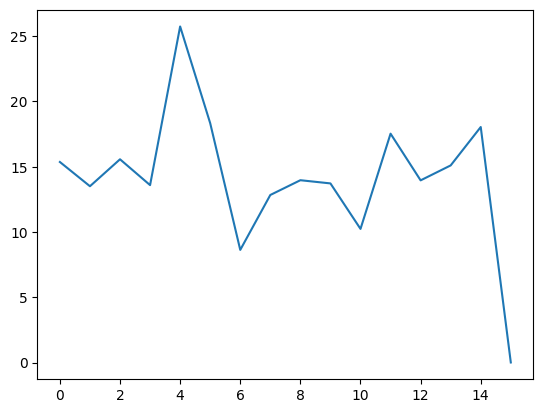

In [57]:
plt.plot(a)

In [25]:
print(X[a[0], a[1]])

tensor([ 0.8821,  1.9823, -1.7985,  1.0440,  0.1138,  0.7790,  1.6197, -0.1221,
        -0.6187,  1.6775])


In [22]:
# get the indices of the upper triangular part of a matrix X 

def upper_triangular_indices(X):
    """
    Get the indices of the upper triangular part of a matrix X.

    inputs: X: (m,m) matrix
    output: (2, m*(m+1)//2) tensor of indices
    """
    m = X.shape[0]
    return torch.triu_indices(m, m)

X = torch.randn(4,4)
print(upper_triangular_indices(X))
# index X with the upper triangular indices
print(X[upper_triangular_indices(X)])

tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3],
        [0, 1, 2, 3, 1, 2, 3, 2, 3, 3]])
tensor([[[ 0.7958,  1.2108, -0.6311, -1.2976],
         [ 0.7958,  1.2108, -0.6311, -1.2976],
         [ 0.7958,  1.2108, -0.6311, -1.2976],
         [ 0.7958,  1.2108, -0.6311, -1.2976],
         [ 0.0139,  0.9568,  2.3916,  1.2499],
         [ 0.0139,  0.9568,  2.3916,  1.2499],
         [ 0.0139,  0.9568,  2.3916,  1.2499],
         [-1.1730, -1.0472,  1.4681,  0.7189],
         [-1.1730, -1.0472,  1.4681,  0.7189],
         [ 0.4664,  1.0660, -1.1296,  1.1420]],

        [[ 0.7958,  1.2108, -0.6311, -1.2976],
         [ 0.0139,  0.9568,  2.3916,  1.2499],
         [-1.1730, -1.0472,  1.4681,  0.7189],
         [ 0.4664,  1.0660, -1.1296,  1.1420],
         [ 0.0139,  0.9568,  2.3916,  1.2499],
         [-1.1730, -1.0472,  1.4681,  0.7189],
         [ 0.4664,  1.0660, -1.1296,  1.1420],
         [-1.1730, -1.0472,  1.4681,  0.7189],
         [ 0.4664,  1.0660, -1.1296,  1.1420],
         [ 0.4664,  1.06

Text(0.5, 1.0, 'Y')

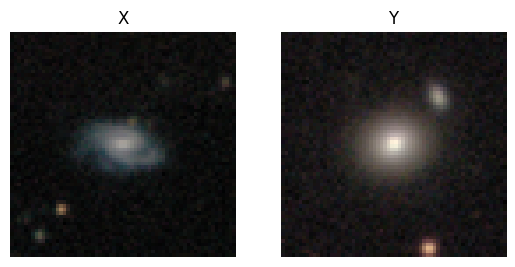

In [120]:
from sampler_galaxy import sampler_galaxy, load_images_list

images_list = load_images_list(highres=False)
X, Y = sampler_galaxy(key = 0, m=1, n=1, corruption = 0.5,images_list=images_list)
# display colorful images
fig, ax = plt.subplots(1, 2)

ax[0].imshow(X[0].int().permute(1, 2, 0))
ax[0].axis('off')
ax[0].set_title('X')
ax[1].imshow(Y[0].int().permute(1, 2, 0))
ax[1].axis('off')
ax[1].set_title('Y')
